In [ ]:
import pandas as pd
import os
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import gensim.corpora as corpora

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
papers = pd.read_csv('/content/BBCNews.csv')

In [ ]:
print("Initial data:\n", papers.head())



Initial data:
    Unnamed: 0                                              descr  \
0           0  chelsea sack mutu  chelsea have sacked adrian ...   
1           1  record fails to lift lacklustre meet  yelena i...   
2           2  edu describes tunnel fracas  arsenals edu has ...   
3           3  ogara revels in ireland victory  ireland flyha...   
4           4  unclear future for striker baros  liverpool fo...   

                                                tags  
0  sports, stamford bridge, football association,...  
1  sports, madrid, birmingham, france, scotland, ...  
2  sports, derby, brazil, tunnel fracasedu, food,...  
3  sports, bbc, united kingdom, ireland, brian o'...  
4  sports, liverpool, daily sport, millennium sta...  


In [ ]:
papers['descr'] = papers['descr'].map(lambda x: re.sub('[,\.!?]', '', x))
papers['descr'] = papers['descr'].map(lambda x: x.lower())

papers['tags'] = papers['tags'].map(lambda x: re.sub('[,\.!?]', '', x))
papers['tags'] = papers['tags'].map(lambda x: x.lower())


In [ ]:
print("Processed data:\n", papers.head())

Processed data:
    Unnamed: 0                                              descr  \
0           0  chelsea sack mutu  chelsea have sacked adrian ...   
1           1  record fails to lift lacklustre meet  yelena i...   
2           2  edu describes tunnel fracas  arsenals edu has ...   
3           3  ogara revels in ireland victory  ireland flyha...   
4           4  unclear future for striker baros  liverpool fo...   

                                                tags  
0  sports stamford bridge football association fi...  
1  sports madrid birmingham france scotland unite...  
2  sports derby brazil tunnel fracasedu food foot...  
3  sports bbc united kingdom ireland brian o'dris...  
4  sports liverpool daily sport millennium stadiu...  


In [ ]:
long_string = ','.join(list(papers['descr'].values))

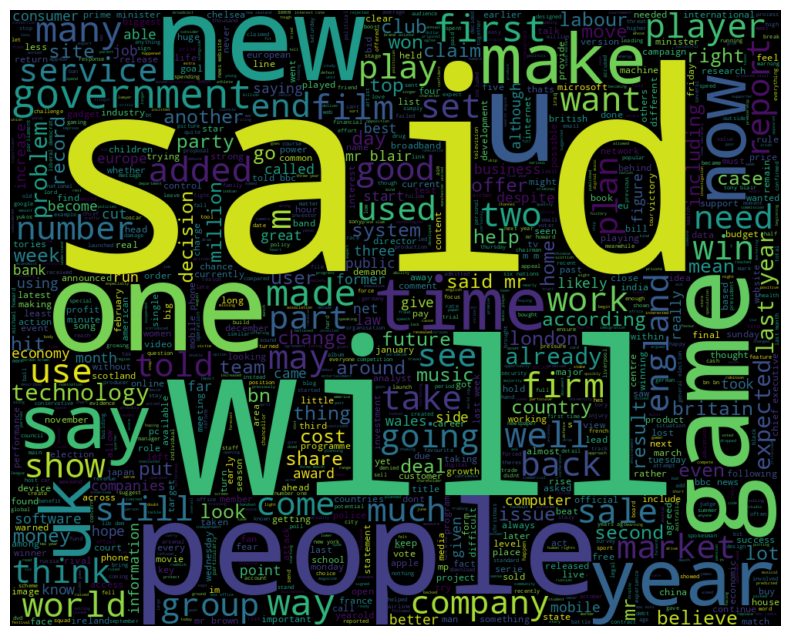

In [ ]:
wordcloud = WordCloud(background_color="black", max_words=5000, contour_width=3, contour_color='steelblue', width=1000, height=800)

wordcloud.generate(long_string)


plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
# Define custom stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'used', 'using', 'use', 'model', 'one', 'two', 'set'])

# Function for converting sentences to words
def sent_to_words(sentences):
    for sentence in sentences:
        yield gensim.utils.simple_preprocess(str(sentence), deacc=True)

# Function for removing stopwords
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]


In [ ]:
# Preprocess the data
data = papers['descr'].values.tolist()  # Create an array of descriptions
data_words = list(sent_to_words(data))  # Convert descriptions to list of words

# Remove stop words
data_words = remove_stopwords(data_words)

# Print the first 30 words of the first processed description
print(data_words[:1][0][:30])



['chelsea', 'sack', 'mutu', 'chelsea', 'sacked', 'adrian', 'mutu', 'failed', 'drugs', 'test', 'yearold', 'tested', 'positive', 'banned', 'substance', 'later', 'denied', 'cocaine', 'october', 'chelsea', 'decided', 'write', 'possible', 'transfer', 'fee', 'mutu', 'signing', 'parma', 'last', 'season']


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Printing the corpus in a numeric form which implies the frequency of the word
print(corpus[:1][0][:30])


[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 1), (22, 8), (23, 2), (24, 2), (25, 1), (26, 4), (27, 1), (28, 1), (29, 2)]


In [ ]:
id2word
from gensim.models import CoherenceModel

In [ ]:
from gensim.models import LdaModel

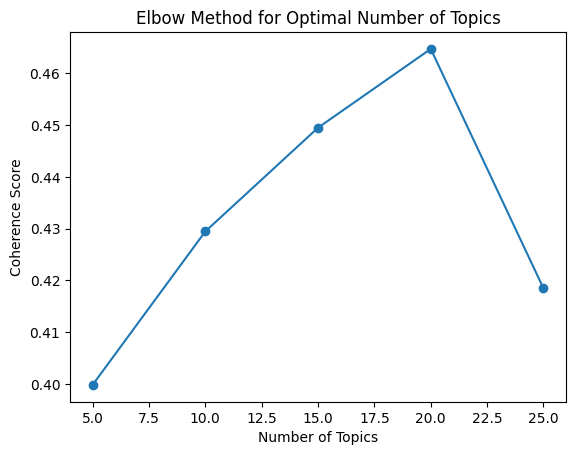

Num Topics = 5, Coherence Score = 0.3998
Num Topics = 10, Coherence Score = 0.4295
Num Topics = 15, Coherence Score = 0.4495
Num Topics = 20, Coherence Score = 0.4647
Num Topics = 25, Coherence Score = 0.4185


In [ ]:
def compute_coherence_values(dictionary, corpus, texts, num_topics_list):
    coherence_values = []
    for num_topics in num_topics_list:
        model = gensim.models.LdaModel(corpus=corpus,
                                        id2word=dictionary,
                                        num_topics=num_topics,
                                        random_state=100,
                                        passes=10,
                                        alpha='auto')
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return coherence_values

# Define the number of topics to try
num_topics_list = [5, 10, 15, 20, 25]

# Compute coherence values
coherence_values = compute_coherence_values(id2word, corpus, data_words, num_topics_list)

# Plot coherence scores
plt.plot(num_topics_list, coherence_values, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Elbow Method for Optimal Number of Topics')
plt.show()

# Print coherence scores
for num_topics, coherence in zip(num_topics_list, coherence_values):
    print(f'Num Topics = {num_topics}, Coherence Score = {coherence:.4f}')


In [ ]:
from gensim.models import LdaModel

# Train the LDA model with 20 topics
lda_model = LdaModel(corpus=corpus,
                     id2word=id2word,
                     num_topics=20,
                     random_state=100,
                     passes=10,
                     alpha='auto')

# Print topics
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)


(0, '0.014*"music" + 0.014*"urban" + 0.010*"said" + 0.008*"people" + 0.007*"us" + 0.007*"home" + 0.007*"police" + 0.006*"without" + 0.006*"joss" + 0.005*"new"')
(1, '0.008*"said" + 0.008*"england" + 0.006*"first" + 0.005*"win" + 0.005*"music" + 0.005*"best" + 0.005*"would" + 0.005*"wales" + 0.005*"good" + 0.005*"think"')
(2, '0.011*"gun" + 0.009*"jeeves" + 0.009*"california" + 0.008*"walmart" + 0.007*"ask" + 0.006*"virgin" + 0.006*"firearms" + 0.005*"said" + 0.005*"republic" + 0.005*"grid"')
(3, '0.023*"ballet" + 0.014*"theatre" + 0.010*"dame" + 0.008*"boys" + 0.008*"musical" + 0.007*"west" + 0.007*"alicia" + 0.006*"kelly" + 0.006*"poppins" + 0.005*"children"')
(4, '0.015*"mr" + 0.011*"said" + 0.008*"deal" + 0.007*"former" + 0.005*"jackson" + 0.005*"president" + 0.005*"directors" + 0.005*"talks" + 0.005*"new" + 0.005*"meeting"')
(5, '0.030*"best" + 0.020*"film" + 0.014*"awards" + 0.011*"said" + 0.010*"award" + 0.010*"actor" + 0.009*"director" + 0.008*"actress" + 0.008*"also" + 0.006*"y

In [ ]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

vis = gensimvis.prepare(lda_model, corpus, id2word)

In [ ]:
pyLDAvis.display(vis)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
